# Kernel methods for a 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 u^3 + C_2 \Delta u = f, & \boldsymbol{x} \in [0,1]^d \\ u = 0, &\boldsymbol{x} \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian.

In [177]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict

In [178]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3 # linewidth

## Reference Solution

We will take the true solution to be 

$$u(x) = \exp\left(-\frac{1}{1-r^2}\right)\left[\sin(\pi x)+\frac{1}{2}\sin(4\pi x)\right] 1_{x \in (0,1)}$$

where $r = 2x-1$.

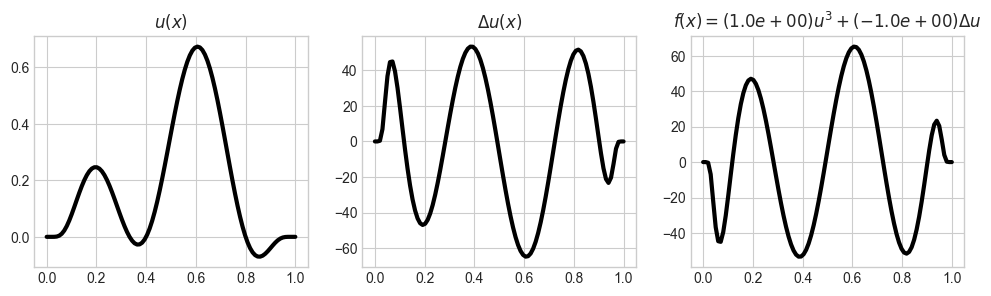

In [179]:
C1 = 1.
C2 = -1.
def u(x):
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = torch.sin(torch.pi*x[b])
    t3 = torch.sin(4*torch.pi*x[b])
    y[b] = t1*(t2+t3)
    return y
def u_laplace(x):
    xg = x.clone().requires_grad_()
    yg = u(xg)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def f(x):
    return C1*u(x)**3+C2*u_laplace(x)
xticks = torch.linspace(0,1,100,dtype=float)
yticks = u(xticks) 
ylticks = u_laplace(xticks)
fticks = f(xticks)
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
ax[0].plot(xticks,yticks,color='k',linewidth=LW)
ax[1].plot(xticks,ylticks,color='k',linewidth=LW)
ax[2].plot(xticks,fticks,color='k',linewidth=LW)
# ax[2].plot(xticks,-u_laplace_1d(xticks))
# ax[2].plot(xticks,tau_1d(u_1d(xticks)))
ax[0].set_title(r"$u(x)$")
ax[1].set_title(r"$\Delta u(x)$")
ax[2].set_title(r"$f(x) = (%.1e) u^3 + (%.1e) \Delta u$"%(C1,C2));

## PDE Setup

In [180]:
ns = torch.tensor([ # number of collocation points
    2**8, #  on the interior
    1 # on the boundary
],dtype=int)
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True], # interior points (not projected to the 0 boundary)
    [False] # boundary points (projected to the 0 boundary) 
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0]],dtype=int), # u
        torch.tensor([[2]],dtype=int)], # laplacian u d^2u/(dx)^2 
    [ # boundary
        torch.tensor([[0]],dtype=int) # u
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # 1*u 
        torch.ones(1,dtype=float) # laplacian 1*d^2u/(dx)^2
    ],
    [ # boundary
        torch.ones(1,dtype=float) # 1*u
    ]
]

In [181]:
def pde_lhs(ly_i, ly_b):
    u_i,u_laplace_i = ly_i
    u_b = ly_b[0] 
    lhs_i = C1*u_i**3+C2*u_laplace_i
    rhs_i = u_b
    return lhs_i,rhs_i
def pde_rhs(x_i, x_b):
    y_i = f(x_i[:,0])
    y_b = torch.zeros(len(x_b),dtype=float)
    return y_i,y_b

## Kernel Interpolant 

### Construction

In [182]:
noise = 1e-3
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,alpha=4,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(lattice,kernel,llbetas,llcs,noise,ns,us) # kernel interpolant

### PDE Optimization

In [183]:
y,losses_opt,rerrors_opt,times_opt = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 25,
    solver = "CHOL",
    verbose = True)

	iter (25 max)       loss           
	1                   3.63e+01       
	2                   4.39e-02       
	3                   7.52e-06       
	4                   7.98e-12       
	5                   6.36e-12       
	6                   7.10e-12       
	7                   6.75e-12       
	8                   6.63e-12       
	9                   6.59e-12       
	10                  6.21e-12       
	11                  5.98e-12       
	12                  6.43e-12       
	13                  6.32e-12       
	14                  6.18e-12       
	15                  6.07e-12       
	16                  6.30e-12       
	17                  6.23e-12       
	18                  6.88e-12       
	19                  6.46e-12       
	20                  7.13e-12       
	21                  5.76e-12       
	22                  6.42e-12       
	23                  6.60e-12       
	24                  6.35e-12       
	25                  6.40e-12       


## Fitting

In [184]:
coeffs,rerrors_fit,times_fit = ki.pcg(y,precond=True)
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
yhat = kvec@coeffs
print("fhat_gauss.shape = %s"%yhat.shape)
print("L2 Rel Error Gauss: %.1e"%(torch.linalg.norm(yhat-yticks)/torch.linalg.norm(yticks)))

fhat_gauss.shape = 100
L2 Rel Error Gauss: 9.4e-01


### Comparison

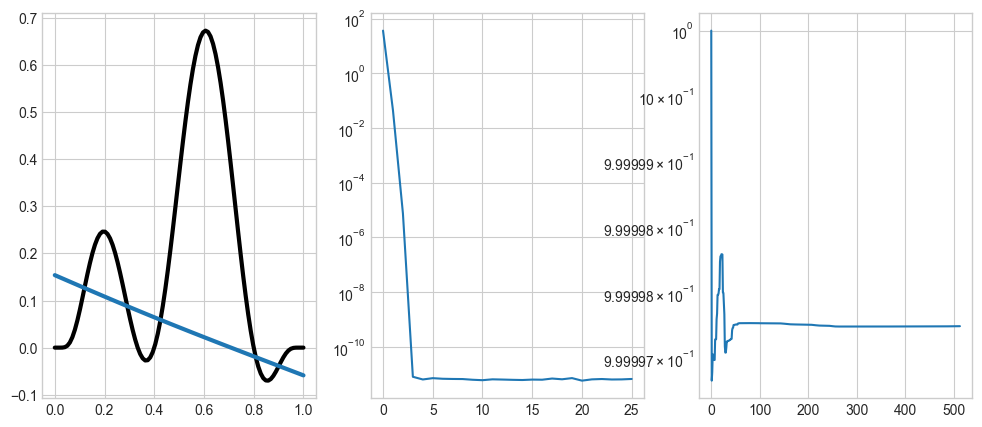

In [186]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,5))
ax[0].plot(xticks,yticks,color="k",linewidth=LW)
ax[0].plot(xticks,yhat,linewidth=LW)
ax[1].plot(torch.arange(len(losses_opt)),losses_opt)
ax[1].set_yscale("log",base=10)
ax[2].plot(torch.arange(len(rerrors_fit)),rerrors_fit)
ax[2].set_yscale("log",base=10)